<a href="https://colab.research.google.com/github/apssouza22/cnn-for-devs/blob/master/g-image-similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image search - Finding similar images
======

In this session we will learn how to build a image search engine.

In [29]:
%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

Parameter Settings
-------------------


In [30]:
num_classes = 10
num_epochs = 30
batch_size = 128
learning_rate = 0.001
use_gpu = True
img_size = 64
conv_dim = 64 * 2 * 7 * 7

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We normalize and center them around 0, which gives a slight performance boost during training.
We create both a training set and a test set.

In [31]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

full_dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
full_dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

In [32]:
# Model responsible for generating our Latent space.
#Latent space, Typically it is a 100-dimensional hypersphere with each variable drawn from a Gaussian distribution with a mean of zero and a standard deviation of one
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=img_size, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=img_size, out_channels=img_size*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=img_size * 2 * 7 * 7, out_features=num_classes)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

# Model responsible for reconstruct the image form our Latent space.
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=num_classes, out_features=img_size*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=img_size * 2, out_channels=img_size, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=img_size, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), img_size * 2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

#The model’s parameters that need to be trained.
num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)


Number of parameters: 396171


Load Pre-Trained Autoencoder
-----------------------------

In this lesson we will leverage from the Autoencoder model we created in the previous lesson. Please run the notebook and upload the wheights generated in assets folder. <a href="https://colab.research.google.com/github/apssouza22/cnn-for-devs/blob/master/f-image-interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
autoencoder.decoder.load_state_dict(torch.load('./assets/decoder.pth'))
autoencoder.encoder.load_state_dict(torch.load('./assets/encoder.pth'))

# this is how the autoencoder parameters can be saved:
# torch.save(autoencoder.state_dict(), './assets/my_autoencoder.pth')

<All keys matched successfully>

Create embedding from the latent space
--------------------------

In [34]:
import numpy as np
def create_embedding(encoder, full_loader, embedding_dim, device):
    """
    Creates embedding using encoder from dataloader.
    encoder: A convolutional Encoder
    full_loader: PyTorch dataloader, containing images over entire dataset.
    embedding_dim: Tuple (c, h, w) Dimension of embedding = output of encoder shape.
    device: "cuda" or "cpu"
    Returns: Embedding of size (num_images_in_loader + 1, c, h, w)
    """
    # Set encoder to eval mode.
    encoder.eval()
    
    embedding = None
    labels = []
    # print(embedding.shape)
    # Again we do not compute loss here so. No gradients.
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
            for _,val in enumerate(target_img):
              labels.append(val.item())
              
            train_img = train_img.to(device)
            # Get encoder outputs and move outputs to cpu
            enc_output = encoder(train_img).cpu()
            if  embedding is not None:
              # embedding = torch.cat((embedding, enc_output), 0)
              embedding = np.row_stack((embedding, enc_output))
            else:
              embedding = enc_output

    return  {"labels": labels, "features": embedding}

EMBEDDING_SHAPE = (conv_dim, num_classes)
index = create_embedding(autoencoder.encoder, full_dataloader, EMBEDDING_SHAPE, device)
# np.save("data_embedding.npy", index)

### Dimensionality reduction
We can use our embedding data and visualize it with [T-NSE algorithm](https://nlml.github.io/in-raw-numpy/in-raw-numpy-t-sne/) 

This means we can take some data that lives in a high-dimensional space  and visualise it in a lower-dimensional space. This is desirable, as humans are much better at understanding data when it is presented in a two- or three-dimensional space.

<img src="https://1.bp.blogspot.com/-lPRGyin_9PE/X79c4SklGoI/AAAAAAAABBw/elm0fQLZCCY6AYUXx9NxNacyWFMog9X3wCLcBGAsYHQ/w640-h480/mnist-tsne.png">

## Calculating image similarity

Let's calculate the distance of two image latent space using euclidean algorithm 

In [35]:
from PIL import Image

# compute and return the euclidean distance between two vectors
def euclidean(a, b):
	return np.linalg.norm(a - b)

def perform_search(queryFeatures, index, maxResults=64):
	results = []

	# loop over our index
	for i in range(0, len(index["features"])):
		# compute the euclidean distance between our query features and the features for the current image in our index, then
		# update our results list with a 2-tuple consisting of the computed distance and the index of the image
		distance = euclidean(queryFeatures, index["features"][i])
		results.append((distance, i))

	# sort the results and grab the top ones
	results = sorted(results)[:maxResults]
	return results

def get_similar_images(img1, num_images, embedding, device):
    with torch.no_grad():
      img1 = img1.to(device)
      image_embedding = autoencoder.encoder(img1).cpu().detach().numpy()

    indices_list = perform_search(image_embedding, index, maxResults=num_images)
    return indices_list

In [36]:
# Grouping digits in a map
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])

    if sum(len(d) for d in digits) >= 1000:
        break;
        
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

## Searching for images with number 7

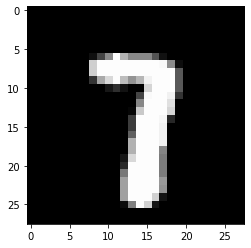

In [37]:
img = digits[7][0]
plt.imshow(img[0,0,:,:], cmap='gray')

In [38]:
import matplotlib.pyplot as plt
indices_list = get_similar_images(img, 10, index["features"], device)

labels =""
for i,val in enumerate(indices_list):
  labels += str(index["labels"][val[1]]) + ","

print(labels)
indices_list


7,7,7,7,7,7,7,7,7,7,


[(7.144622e-07, 68510),
 (0.8851903, 68525),
 (1.1556448, 68541),
 (1.1832607, 1251),
 (1.2905456, 1564),
 (1.2934818, 68497),
 (1.3046018, 16194),
 (1.3226087, 68519),
 (1.3259156, 44610),
 (1.3440713, 1281)]

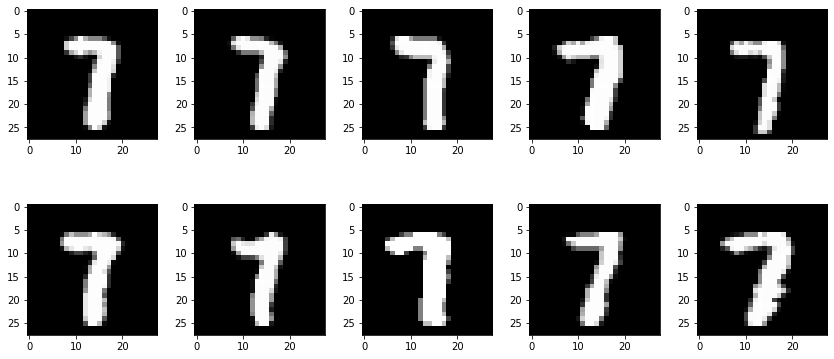

In [39]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i,val in enumerate(indices_list):
  img, lbl = full_dataloader.dataset[val[1]]
  inter_image = to_img(img)
  image = inter_image.numpy()
  axs[i].imshow(img.squeeze(), cmap='gray')

plt.show() 